# OONI Data Analysis - Preliminary Exploration

In [2]:
# Imports
from matplotlib import pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import os
from urllib.parse import urlparse

In [3]:
# Plot configuration
seaborn.set_style('dark')

## (1) Data Cleaning
In this step we load and clean up the pre-procsesed data in order to get it into a form that can be analyzed.

In [4]:
# Load the pre-processed data and set up the index based on date
data_dir = '../results/BY/processed/2022/'
web_connectivity = pd.read_csv(os.path.join(data_dir, 'webconnectivity.csv'))
web_connectivity['date'] = pd.to_datetime(web_connectivity['date'])
web_connectivity = web_connectivity.set_index('date')
web_connectivity

,probe_asn,control_failure,body_length_match,accessible,input,resolver_asn,dns_consistency,x_null_null_flags,status_code_match,title_match,blocking,dns_experiment_failure,x_blocking_flags,x_dns_flags,body_proportion,http_experiment_failure,headers_match
date,,,,,,,,,,,,,,,,,
2022-01-01,AS42772,NaN,True,True,https://cc.bingj.com/cache.aspx?q=nothing,AS42772,consistent,NaN,True,NaN,False,NaN,NaN,NaN,1.0,NaN,True
2022-01-01,AS42772,NaN,True,True,https://coronavirus.app/,AS42772,consistent,NaN,True,True,False,NaN,NaN,NaN,1.0,NaN,True
2022-01-01,AS42772,NaN,NaN,True,https://hootsuite.com/,AS42772,consistent,NaN,True,NaN,False,NaN,NaN,NaN,0.0,NaN,True
2022-01-01,AS42772,NaN,True,True,http://www.akdn.org/,AS42772,inconsistent,NaN,True,True,False,NaN,NaN,NaN,1.0,NaN,True
2022-01-01,AS42772,NaN,True,True,http://www.allminsk.biz/,AS42772,consistent,NaN,True,False,False,NaN,NaN,NaN,1.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,AS6697,NaN,True,True,http://www.granma.cu/,AS6697,consistent,NaN,True,True,False,NaN,NaN,NaN,1.0,NaN,True
2022-12-31,AS6697,NaN,True,True,https://www.grindr.com/,AS6697,consistent,NaN,True,True,False,NaN,NaN,NaN,1.0,NaN,True
2022-12-31,AS6697,NaN,True,True,https://www.guerrillagirls.com/,AS6697,consistent,NaN,True,True,False,NaN,NaN,NaN,1.0,NaN,True


In [5]:
# Standardize URLs
def url_standardize(url):
    p = urlparse(url)
    b = p.netloc.split('.')
    c = '.'.join(b[len(b)-2:])  # Remove any www
    return c+p.path
    
web_connectivity['input'] = web_connectivity['input'].map(url_standardize)

In [6]:
# Filter data into specific blocking methods
dns_events = web_connectivity[web_connectivity['blocking'] == 'dns']
httpdiff_events = web_connectivity[web_connectivity['blocking'] == 'http-diff']
httpfail_events = web_connectivity[web_connectivity['blocking'] == 'http-failure']
tcp_events = web_connectivity[web_connectivity['blocking'] == 'tcp_ip']
web_connectivity['blocking'].unique()

array(['False', 'dns', 'http-diff', nan, 'tcp_ip', 'http-failure'],
      dtype=object)

## (2) Data Exploration

In [7]:
# Compute rolling totals
k=7
date_range = pd.date_range(start="2022-01-01", end="2022-12-31", freq='D')

temp_events = web_connectivity.groupby(web_connectivity.index).size()
total_events = temp_events.reindex(date_range, fill_value=0).rolling(window=k).sum().dropna()

temp_dns = dns_events.groupby(dns_events.index).size()
total_dns = temp_dns.reindex(date_range, fill_value=0).rolling(window=k).sum().dropna()

temp_httpdiff = httpdiff_events.groupby(httpdiff_events.index).size()
total_httpdiff = temp_httpdiff.reindex(date_range, fill_value=0).rolling(window=k).sum().dropna()

temp_httpfail = httpfail_events.groupby(httpfail_events.index).size()
total_httpfail = temp_httpfail.reindex(date_range, fill_value=0).rolling(window=k).sum().dropna()

temp_tcp = tcp_events.groupby(tcp_events.index).size()
total_tcp = temp_tcp.reindex(date_range, fill_value=0).rolling(window=k).sum().dropna()

In [8]:
# Compute fractional events
frac_dns = total_dns/total_events
frac_httpdiff = total_httpdiff/total_events
frac_httpfail = total_httpfail/total_events
frac_tcp = total_tcp/total_events
frac_dns = frac_dns.fillna(0)
frac_httpdiff = frac_httpdiff.fillna(0)
frac_httpfail = frac_httpfail.fillna(0)
frac_tcp = frac_tcp.fillna(0)

Text(0.5, 1.0, 'Fractional Blocking Events Over Time (k=7)')

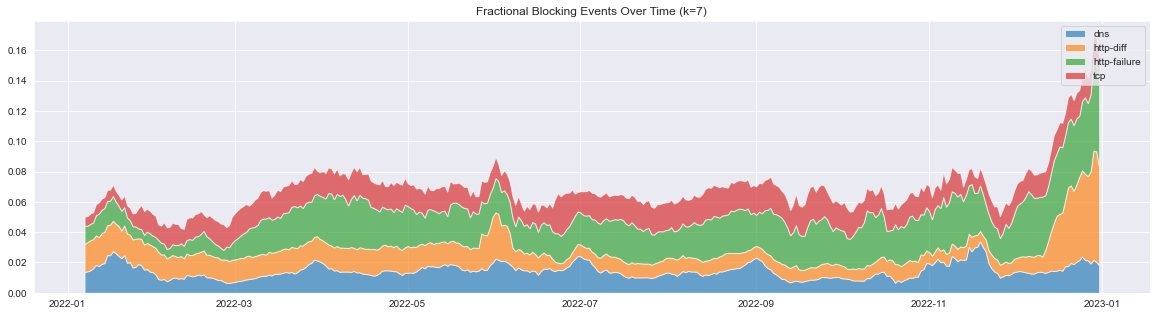

In [9]:
# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(total_events.index, frac_dns, frac_httpdiff, frac_httpfail, frac_tcp, labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events Over Time (k={k})')

Text(0.5, 1.0, 'Fractional Blocking Events From 2022-03-24-2022-04-18 (k=7)')

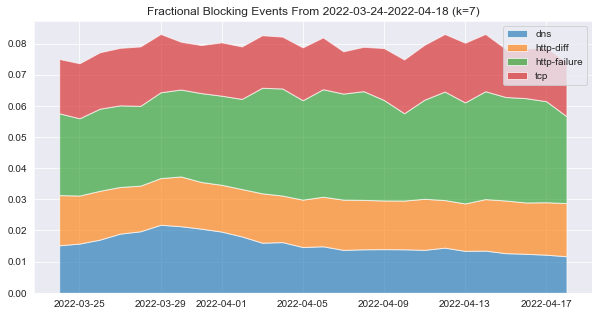

In [11]:
# Zoom in on a region of interest
start_date = '2022-03-24'
end_date = '2022-04-18'
filter_range = total_events.index[(total_events.index >= start_date) & (total_events.index <= end_date)]
plt.rcParams['figure.figsize'] = [10, 5]
plt.stackplot(filter_range, frac_dns[filter_range], frac_httpdiff[filter_range], frac_httpfail[filter_range], frac_tcp[filter_range], labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events From {start_date}-{end_date} (k={k})')

In [12]:
# Get blocking events in small date range
filter_tcp_range = (tcp_events.index >= start_date) & (tcp_events.index <= end_date)
filter_total_range = (web_connectivity.index >= start_date) & (web_connectivity.index <= end_date)
tcp_during = tcp_events[filter_tcp_range].groupby('input').size()
total_during = web_connectivity[filter_total_range].groupby('input').size()
frac_tcp_during = (tcp_during/total_during).fillna(0)
tcp_during.sort_values(ascending=False)
#print((tcp_during/total_during.sum()).sort_values(ascending=False)[:20])
tcp_out = tcp_events[~filter_tcp_range].groupby('input').size()
total_out = web_connectivity[~filter_total_range].groupby('input').size()
frac_tcp_out = (tcp_out/total_out).fillna(0)
#print((tcp_out/total_out.sum()).sort_values(ascending=False)[:20])
diff_frac_tcp = (frac_tcp_during-frac_tcp_out).sort_values(ascending=False).dropna()
diff_frac_tcp[:30]

input
i2p2.de/                           0.848193
3dway.org/                         0.651390
dailystormer.su/                   0.487170
proxyweb.net/                      0.458549
posteo.de/                         0.360073
teenhealthfx.com/                  0.341499
blog.com/                          0.281835
tutanota.com/                      0.276686
hdreactor.club/                    0.272256
vitebsk.ws/                        0.260217
proxpn.com/                        0.255102
searx.me/                          0.254886
hon.ch/                            0.182450
cock.li/                           0.119920
iwhc.org/                          0.118537
csidonline.org/                    0.117128
164.118/tor/server/authority       0.103898
mhut.org/                          0.102792
libgen.life/                       0.101266
175.225/tor/server/authority       0.097979
193.9:443/tor/server/authority     0.091199
21.38/tor/server/authority         0.088885
libgen.fun/               

In [13]:
from statsmodels.stats.proportion import proportions_ztest

blocking_start = "2022-03-24"
blocking_end = "2022-04-18"

inner_range = (web_connectivity.index >= start_date) & (web_connectivity.index <= end_date)
outer_range = (web_connectivity.index < start_date) | (web_connectivity.index > end_date)
tcp_during = web_connectivity[inner_range].groupby('blocking').size()
tcp_outside = web_connectivity[outer_range].groupby('blocking').size()

successes = [tcp_during.sum() - tcp_during["False"], tcp_outside.sum() - tcp_outside["False"]]
sample_sizes = [tcp_during.sum(), tcp_outside.sum()]
print(successes)
print(sample_sizes)
z_stat, p_value = proportions_ztest(successes, sample_sizes)
print(f"Z-Statistic: {z_stat}")
print(f"P-Value: {p_value}")
print(successes[0] / sample_sizes[0])
print(successes[1] / sample_sizes[1])

[13573, 107557]
[166031, 1533767]
Z-Statistic: 17.48832547830654
P-Value: 1.7584874724390595e-68
0.08174979371322223
0.07012603609283548


In [14]:
import scipy.stats as stats

# Chi-square test of independence of variables
grouped_frame = pd.DataFrame({
    "during": tcp_during,
    "outside": tcp_outside
})
chi2, p_value, dof, expected = stats.chi2_contingency(grouped_frame.T)  # .T to transpose and get the correct format

# Step 3: Output the results
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")

Chi-square statistic: 408.41016819377927
P-value: 4.236887344914032e-87


In [13]:
tcp_blocked = tcp_events[filter_tcp_range].groupby('input').size()
print(len(tcp_blocked))
for i, j in tcp_during.items():
    print(str(i) + " " + str(j))

158
False 152458
dns 2687
http-diff 2766
http-failure 5158
tcp_ip 2962


Text(0.5, 1.0, 'Fractional Blocking Events Over Time (k=7)')

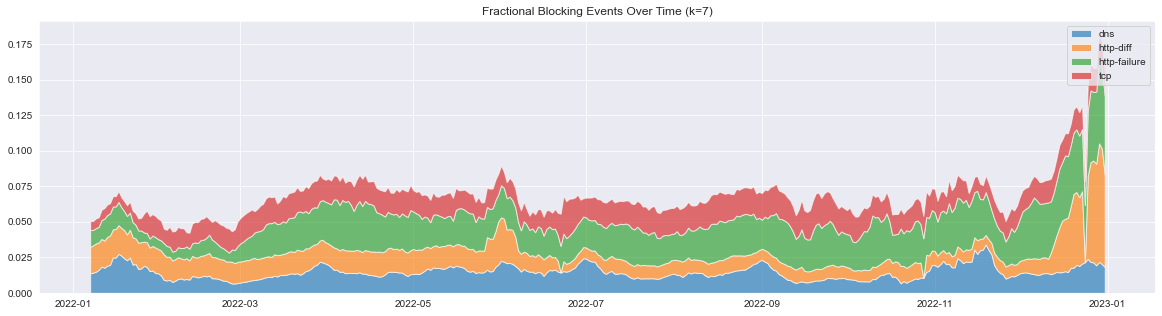

In [14]:
# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(total_events.index, frac_dns, frac_httpdiff, frac_httpfail, frac_tcp, labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events Over Time (k={k})')

In [15]:
# Extract known blocking methods
web_maybe_blocked = web_connectivity.loc[(web_connectivity['blocking'] != 'False') & (~web_connectivity['blocking'].isnull())]
web_maybe_blocked = web_maybe_blocked.sort_values(by=["input", "date"])
wmbi = web_maybe_blocked.set_index(['input', web_maybe_blocked.index])
wmbi

probe_asn control_failure  \
input                          date                                   
0.39:9131/tor/server/authority 2022-01-26   AS42772             NaN   
                               2022-01-26    AS6697             NaN   
                               2022-01-26    AS6697             NaN   
                               2022-01-26   AS42772             NaN   
                               2022-01-26   AS42772             NaN   
...                                             ...             ...   
zzn.com/                       2022-12-20    AS6697             NaN   
                               2022-12-22    AS6697             NaN   
                               2022-12-26    AS6697             NaN   
                               2022-12-27    AS6697             NaN   
                               2022-12-29    AS6697             NaN   

                                          body_length_match accessible  \
input                          date                                      
0.39:9131/tor/server/authority 2022-01-26               NaN      False   
                               2022-01-26               NaN      False   
                               2022-01-26               NaN      False   
                               2022-01-26               NaN      False   
                               2022-01-26               NaN      False   
...                                                     ...        ...   
zzn.com/                       2022-12-20             False      False   
                               2022-12-22             False      False   
                               2022-12-26             False      False   
                               2022-12-27             False      False   
                               2022-12-29             False      False   

                                          resolver_asn dns_consistency  \
input                          date                                      
0.39:9131/tor/server/authority 2022-01-26      AS15169      consistent   
                               2022-01-26          AS0      consistent   
                               2022-01-26      AS14618      consistent   
                               2022-01-26         AS42      consistent   
                               2022-01-26      AS15169      consistent   
...                                                ...             ...   
zzn.com/                       2022-12-20       AS6697      consistent   
                               2022-12-22       AS6697      consistent   
                               2022-12-26       AS6697      consistent   
                               2022-12-27       AS6697      consistent   
                               2022-12-29       AS6697      consistent   

                                           x_null_null_flags  \
input                          date                            
0.39:9131/tor/server/authority 2022-01-26                NaN   
                               2022-01-26                NaN   
                               2022-01-26                NaN   
                               2022-01-26                NaN   
                               2022-01-26                NaN   
...                                                      ...   
zzn.com/                       2022-12-20                NaN   
                               2022-12-22                NaN   
                               2022-12-26                NaN   
                               2022-12-27                NaN   
                               2022-12-29                NaN   

                                          status_code_match title_match  \
input                          date                                       
0.39:9131/tor/server/authority 2022-01-26               NaN         NaN   
                               2022-01-26               NaN         NaN   
                               2022-01-26               NaN

In [16]:
# Find sites with largest number of blocking events
topw = wmbi.groupby(level=0).size().sort_values(ascending=False)
topw

input
intex-press.by/          1641
torproject.org/          1613
spring96.org/            1590
vitebsk.cc/              1176
dw.com/                  1112
                         ... 
thetrevorproject.org/       1
lingerieatlarge.com/        1
genymotion.com/             1
getintra.org/               1
netflix.com/                1
Length: 1710, dtype: int64

In [17]:
# Get data from the top blocking events
wmbi.loc[topw[topw > 10].index]

probe_asn control_failure body_length_match  \
input           date                                                     
intex-press.by/ 2022-01-02    AS6697             NaN             False   
                2022-01-03   AS42772             NaN             False   
                2022-01-03    AS6697             NaN               NaN   
                2022-01-03   AS42772             NaN             False   
                2022-01-04   AS42772             NaN             False   
...                              ...             ...               ...   
fotolog.com/    2022-12-15    AS6697             NaN             False   
                2022-12-21    AS6697             NaN             False   
                2022-12-22    AS6697             NaN             False   
                2022-12-26    AS6697             NaN             False   
                2022-12-30    AS6697             NaN             False   

                           accessible resolver_asn dns_consistency  \
input           date                                                 
intex-press.by/ 2022-01-02      False      AS14618      consistent   
                2022-01-03      False         AS42      consistent   
                2022-01-03      False          AS0      consistent   
                2022-01-03      False      AS49544      consistent   
                2022-01-04      False          AS0      consistent   
...                               ...          ...             ...   
fotolog.com/    2022-12-15      False       AS6697      consistent   
                2022-12-21      False       AS6697      consistent   
                2022-12-22      False       AS6697      consistent   
                2022-12-26      False       AS6697      consistent   
                2022-12-30      False       AS6697      consistent   

                            x_null_null_flags status_code_match title_match  \
input           date                                                          
intex-press.by/ 2022-01-02                NaN              True         NaN   
                2022-01-03                NaN              True       False   
                2022-01-03                NaN               NaN         NaN   
                2022-01-03                NaN              True       False   
                2022-01-04                NaN              True       False   
...                                       ...               ...         ...   
fotolog.com/    2022-12-15                NaN             False       False   
                2022-12-21                NaN             False       False   
                2022-12-22                NaN             False       False   
                2022-12-26                NaN             False       False   
                2022-12-30                NaN             False       False   

                                blocking dns_experiment_failure  \
input           date                                              
intex-press.by/ 2022-01-02     http-diff                    NaN   
                2022-01-03     http-diff                    NaN   
                2022-01-03  http-failure                    NaN   
                2022-01-03     http-diff                    NaN   
                2022-01-04     http-diff                    NaN   
...                                  ...                    ...   
fotolog.com/    2022-12-15     http-diff                    NaN   
                2022-12-21     http-diff                    NaN   
                2022-12-22     http-diff                    NaN   
                2022-12-26     http-diff                    NaN   
                2022-12-30     http-diff                    NaN   

                            x_blocking_flags  x_dns_flags  body_proportion  \
input           date                                                         
intex-press.by/ 2022-01-02               NaN          NaN         0.005191   
                202

In [18]:
sel = wmbi.loc[topw[topw > 10].index].loc[topw.index[10]]
ma = sel['blocking'] == 'dns'
sel[ma]

,probe_asn,control_failure,body_length_match,accessible,resolver_asn,dns_consistency,x_null_null_flags,status_code_match,title_match,blocking,dns_experiment_failure,x_blocking_flags,x_dns_flags,body_proportion,http_experiment_failure,headers_match
date,,,,,,,,,,,,,,,,


In [19]:
web_connectivity.loc[web_connectivity['input'] == topw.index[0]]

,probe_asn,control_failure,body_length_match,accessible,input,resolver_asn,dns_consistency,x_null_null_flags,status_code_match,title_match,blocking,dns_experiment_failure,x_blocking_flags,x_dns_flags,body_proportion,http_experiment_failure,headers_match
date,,,,,,,,,,,,,,,,,
2022-01-01,AS42772,NaN,NaN,True,intex-press.by/,AS0,consistent,NaN,True,NaN,False,NaN,NaN,NaN,0.000000,NaN,True
2022-01-01,AS42772,NaN,NaN,True,intex-press.by/,AS42,consistent,NaN,True,NaN,False,NaN,NaN,NaN,0.000000,NaN,True
2022-01-02,AS42772,NaN,NaN,True,intex-press.by/,AS42,consistent,NaN,True,NaN,False,NaN,NaN,NaN,0.000000,NaN,True
2022-01-02,AS42772,NaN,NaN,True,intex-press.by/,AS0,consistent,NaN,True,NaN,False,NaN,NaN,NaN,0.000000,NaN,True
2022-01-02,AS6697,NaN,False,False,intex-press.by/,AS14618,consistent,NaN,True,NaN,http-diff,NaN,NaN,NaN,0.005191,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,AS6697,NaN,NaN,False,intex-press.by/,AS6697,consistent,NaN,NaN,NaN,http-failure,NaN,NaN,NaN,0.000000,connection_reset,NaN
2022-12-31,AS6697,NaN,NaN,False,intex-press.by/,AS6697,consistent,NaN,NaN,NaN,http-failure,NaN,NaN,NaN,0.000000,connection_reset,NaN
2022-12-31,AS6697,NaN,NaN,False,intex-press.by/,AS6697,consistent,NaN,NaN,NaN,http-failure,NaN,NaN,NaN,0.000000,connection_reset,NaN


In [20]:
# Group all events by input calculate totals
dns_grouped = dns_events.groupby('input').size() # sort_values(ascending=False)
httpdiff_grouped = httpdiff_events.groupby('input').size()
httpfail_grouped = httpfail_events.groupby('input').size()
tcp_grouped = tcp_events.groupby('input').size()
totals_grouped = web_connectivity.groupby('input').size()

In [21]:
noblock_events = web_connectivity[(web_connectivity['blocking'] == 'False') | (web_connectivity['blocking'].isnull())]
noblock_grouped = noblock_events.groupby('input').size()

In [22]:
# Calculate fraction of events blocked per input
frac_dns_grouped = (dns_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_httpdiff_grouped = (httpdiff_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_httpfail_grouped = (httpfail_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_tcp_grouped = (tcp_grouped / totals_grouped).dropna().sort_values(ascending=False)

In [23]:
# Get all events grouped by the type of blocking event
all_grouped = pd.DataFrame({'dns': frac_dns_grouped, 'httpdiff': frac_httpdiff_grouped, 'httpfail': frac_httpfail_grouped, 'tcp': frac_tcp_grouped}).fillna(0)
all_grouped

,dns,httpdiff,httpfail,tcp
input,,,,
0.39:9131/tor/server/authority,0.000000,0.000000,0.000000,0.898701
015.by/search/,0.071648,0.000000,0.000000,0.286592
1.1/dns-query,0.000000,0.000000,0.001129,0.000000
1.3/dns-query,0.000000,0.000000,0.001115,0.000000
100webspace.com/,0.000000,0.000000,0.001261,0.013871
...,...,...,...,...
zoomshare.com/,0.000000,0.000000,0.003567,0.015458
zubr.cc/,0.042650,0.000000,0.449183,0.000000
zubr.in/,0.083784,0.000000,0.404505,0.000000


In [24]:
# Extract the top N sites
nn = 100
top_n_idx = all_grouped.sum(axis=1).sort_values(ascending=False)[0:nn].index
top_n = all_grouped.loc[top_n_idx]
top_n

,dns,httpdiff,httpfail,tcp
input,,,,
change.org/p/istari-ru-%D0%BB%D0%B8%D1%86%D0%B5%D0%BD%D0%B7%D0%B8%D1%8F-%D0%BD%D0%B0-%D1%83-%D0%BA%D0%BE%D0%BC%D0%B8-%D1%81%D0%B0%D0%BD-%D0%BF%D1%80%D0%BE%D0%B1%D0%BB%D0%B5%D0%BC%D1%8B-%D1%81-%D0%BE%D0%B1%D1%89%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC,1.000000,0.0,0.000000,0.0
hdrezka.ag,0.000000,0.0,1.000000,0.0
baskino.me,0.000000,0.0,1.000000,0.0
iwantim.com/,0.000000,0.0,0.000000,1.0
xiaomi.com/pass/serviceLogin,1.000000,0.0,0.000000,0.0
...,...,...,...,...
williamhill.com/,0.078431,0.0,0.470588,0.0
belsat.eu/ru/,0.121392,0.0,0.426995,0.0
politzek.me/,0.249438,0.0,0.298876,0.0


In [25]:
# Calculate cumulative values
c_top_n = top_n.cumsum(axis=1)

Text(0.5, 0, 'Fraction of events')

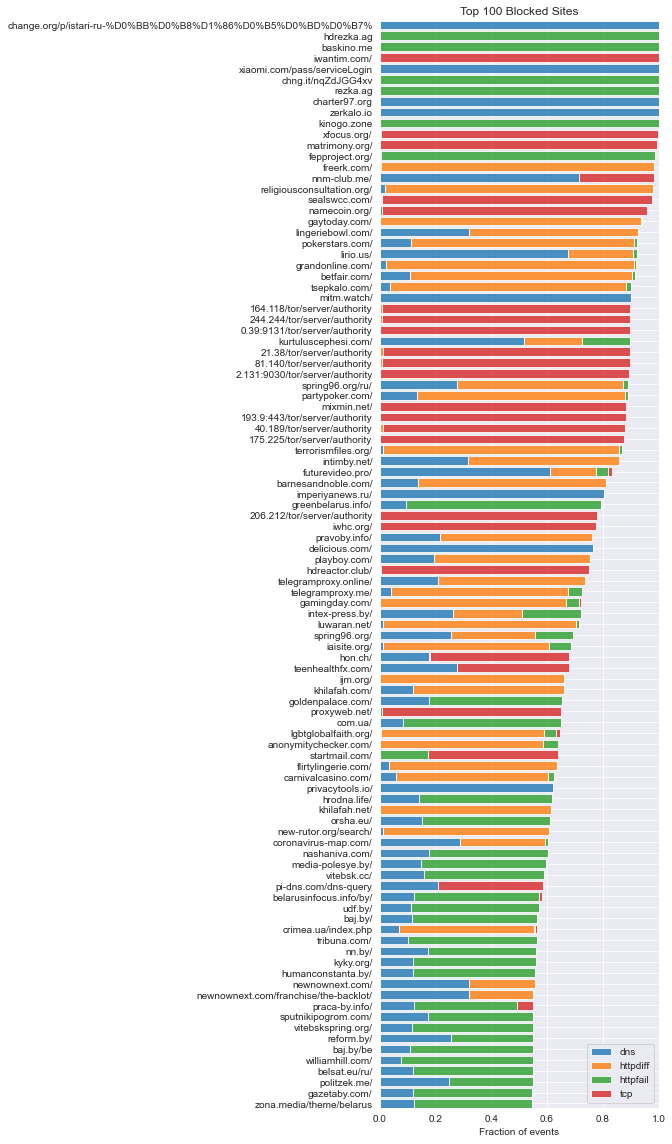

In [26]:
# Plot 
plt.rcParams['figure.figsize'] = [5, 20]
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['dns'].iloc[::-1], label='dns', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['httpdiff'].iloc[::-1], left=c_top_n.iloc[::-1,0], label='httpdiff', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['httpfail'].iloc[::-1], left=c_top_n.iloc[::-1,1], label='httpfail', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['tcp'].iloc[::-1], left=c_top_n.iloc[::-1,2], label='tcp', alpha=0.8)
plt.margins(y=0)
plt.legend()
plt.grid()
plt.title(f'Top {nn} Blocked Sites')
plt.xlabel('Fraction of events')